# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [1]:
# If this cell does not work try running ``

import io
import nbformat

nb = nbformat.read("Lab1.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 444


## Group Number :

## Student 1 
### Name : Krzysztof Baran
### ID : 4662148

## Student 2
### Name : Michał Okoń
### ID :

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [2]:
py_version = !python --version
print(py_version[0])
print("+++++++++++++")
import sklearn
print("scikit-learn", sklearn.__version__)
import pandas
print("pandas", pandas.__version__)
import seaborn
print("seaborn", seaborn.__version__)
import matplotlib
print("matplotlib", matplotlib.__version__)
import imblearn
print("imbalanced-learn", imblearn.__version__)
import plotly
print("plotly", plotly.__version__)
import nbformat
print("nbformat", nbformat.__version__)
import statsmodels
print("statsmodels", statsmodels.__version__)
import tensorflow as tf
print("tensorflow", tf.__version__)
import tensorflow_data_validation as tfdv
print("tensorflow_data_validation", tfdv.__version__)

Python 3.9.16
+++++++++++++
scikit-learn 1.0.2
pandas 1.4.2
seaborn 0.11.2
matplotlib 3.5.1
imbalanced-learn 0.9.0
plotly 5.8.0
nbformat 5.4.0
statsmodels 0.13.2


2023-05-09 09:59:49.620493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 09:59:49.672875: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 09:59:49.675012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 09:59:50.677465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow 2.12.0
tensorflow_data_validation 1.13.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow_data_validation as tfdv
import tensorflow as tf

In [4]:
def col(rgb, text):
    r, g, b = rgb
    return f"\033[38;2;{r};{g};{b}m{text} \033[0m"
print(col((255, 0, 0), "Test"))

Test 


## 1. Visualization task – 1 A4

### 1a. Plot visulations 

In [5]:
# Load the data inside pandas Dataframe
import os

train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

#### Train and Test data

Firstly, it is vital to understand how the Train and Test datasets differ. We start by examining the basic statistics of both datasets, such as the mean, standard deviation, minimum, and maximum values for each feature. We can also visualize the distribution of each feature in both datasets using heat maps, box plots, bar charts and density plots.

In [6]:
train_data_df.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
Id,,,,,,,,,,,,,,
1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


In [7]:
test_data_df.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
Id,,,,,,,,,,,,,
0,GB,visadebit,492181.0,1095.0,GBP,GB,Ecommerce,NaN,1,UKAccount,email327589,ip144935,card115008
5,GB,mcdebit,557379.0,5400.0,GBP,GB,Ecommerce,True,1,UKAccount,email273226,ip12784,card20633
7,GB,visaplatinum,492913.0,17510.0,GBP,GB,Ecommerce,True,1,UKAccount,email67749,ip194560,card130375
9,NZ,visadebit,494310.0,15000.0,NZD,NZ,Ecommerce,True,0,APACAccount,email55458,ip130239,card195989
16,AU,mccredit,518868.0,11050.0,AUD,AU,Ecommerce,True,0,APACAccount,email190209,ip31190,card155450


**Columns differences**

Checks how Train and Test data differ in columns. In this case, test does not contain labels.

In [39]:
train_data_cols = list(train_data_df.columns.values)
test_data_cols = list(test_data_df.columns.values)

LIGHT_GREEN = (45, 179, 0)

print(col(LIGHT_GREEN, "Train data Columns: "), train_data_cols)
print(col(LIGHT_GREEN, "Test  data Columns: "), test_data_cols)

set_difference = set(train_data_cols) - set(test_data_cols)
list_difference = list(set_difference)


print(col(LIGHT_GREEN, "\nColumns Diff: "), list_difference)

Train data Columns:   ['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode', 'mail_id', 'ip_id', 'card_id', 'label']
Test  data Columns:   ['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode', 'mail_id', 'ip_id', 'card_id']

Columns Diff:   ['label']


In [17]:
train_stats = tfdv.generate_statistics_from_csv(train_data_path, delimiter=',')
test_stats = tfdv.generate_statistics_from_csv(test_data_path, delimiter=',')
tfdv.visualize_statistics(lhs_statistics=train_stats, rhs_statistics=test_stats,
                          lhs_name='TRAIN_DATASET', rhs_name='TEST_DATASET')

In [25]:
schema = tfdv.infer_schema(statistics=train_stats, max_string_domain_size=200)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Id',INT,required,,-
'issuercountrycode',STRING,optional,single,'issuercountrycode'
'txvariantcode',STRING,required,,'txvariantcode'
'bin',FLOAT,required,,-
'amount',FLOAT,required,,-
'currencycode',STRING,required,,'currencycode'
'shoppercountrycode',STRING,optional,single,'shoppercountrycode'
'shopperinteraction',STRING,required,,'shopperinteraction'
'cardverificationcodesupplied',STRING,optional,single,'cardverificationcodesupplied'


,Values
Domain,
'issuercountrycode',"'AE', 'AI', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BG', 'BH', 'BM', 'BN', 'BR', 'BW', 'BY', 'CA', 'CH', 'CK', 'CL', 'CN', 'CO', 'CR', 'CW', 'CY', 'DE', 'DK', 'EC', 'EE', 'EG', 'ES', 'FI', 'FJ', 'FR', 'GB', 'GE', 'GH', 'GI', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IS', 'IT', 'JO', 'JP', 'KE', 'KH', 'KR', 'KW', 'KZ', 'LA', 'LB', 'LK', 'LT', 'LU', 'LV', 'LY', 'MD', 'ME', 'MK', 'MN', 'MO', 'MT', 'MU', 'MX', 'MY', 'NG', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PK', 'PL', 'PT', 'PY', 'QA', 'RO', 'RS', 'RU', 'SA', 'SB', 'SE', 'SG', 'SI', 'SK', 'SL', 'TH', 'TR', 'TW', 'TZ', 'UA', 'US', 'UY', 'VG', 'VN', 'ZA', 'ZM', 'ZW', 'ZZ'"
'txvariantcode',"'electron', 'mc', 'mccredit', 'mcdebit', 'visa', 'visabusiness', 'visaclassic', 'visacorporate', 'visadebit', 'visagold', 'visaplatinum', 'visapurchasing', 'visasignature'"
'currencycode',"'AUD', 'GBP', 'MXN', 'NZD', 'SEK'"
'shoppercountrycode',"'AE', 'AF', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AX', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BG', 'BH', 'BM', 'BN', 'BO', 'BR', 'BS', 'BW', 'BY', 'CA', 'CD', 'CH', 'CI', 'CK', 'CL', 'CN', 'CO', 'CR', 'CV', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DZ', 'EE', 'EG', 'ES', 'FI', 'FJ', 'FR', 'GB', 'GD', 'GE', 'GG', 'GH', 'GI', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IM', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JE', 'JM', 'JO', 'JP', 'KE', 'KH', 'KN', 'KR', 'KW', 'KY', 'KZ', 'LB', 'LC', 'LK', 'LT', 'LU', 'LV', 'LY', 'MA', 'MC', 'MD', 'ME', 'MK', 'MO', 'MT', 'MU', 'MV', 'MW', 'MX', 'MY', 'MZ', 'NG', 'NL', 'NO', 'NP', 'NZ', 'OM', 'PE', 'PH', 'PK', 'PL', 'PR', 'PT', 'QA', 'RO', 'RS', 'RU', 'SA', 'SC', 'SD', 'SE', 'SG', 'SI', 'SK', 'SL', 'TH', 'TR', 'TT', 'TW', 'TZ', 'UA', 'UG', 'US', 'UZ', 'VN', 'VU', 'ZA', 'ZM', 'ZW'"
'shopperinteraction',"'ContAuth', 'Ecommerce', 'POS'"
'cardverificationcodesupplied',"'False', 'True'"
'accountcode',"'APACAccount', 'MexicoAccount', 'SwedenAccount', 'UKAccount'"


In [20]:
train_data_df['label'].value_counts()

0    189352
1       276
Name: label, dtype: int64

In [117]:
fraudulent_test_df = train_data_df[['currencycode','shoppercountrycode', 'label']]
fraudulent_test_df.loc[fraudulent_test_df['shoppercountrycode'].isna(),'shoppercountrycode'] = '-'
fraudulent_test_df.reset_index(drop=True, inplace=True)
fraudulent_test_df.head()

,currencycode,shoppercountrycode,label
0,GBP,GB,0
1,GBP,GB,0
2,GBP,GB,0
3,GBP,GB,0
4,GBP,GB,0


In [118]:
counts_df = fraudulent_test_df.groupby(['shoppercountrycode','currencycode', 'label']).size().reset_index().rename(columns={0:'count'})
counts_df

,shoppercountrycode,currencycode,label,count
0,-,AUD,0,33
1,-,GBP,0,202
2,-,MXN,0,1
3,-,NZD,0,3
4,-,SEK,0,30
...,...,...,...,...
266,ZA,AUD,0,2
267,ZA,GBP,0,42
268,ZA,NZD,0,1
269,ZM,GBP,0,3


In [158]:
fraud_df = counts_df.copy(deep=True)
fraud_df.loc[fraud_df['label'] == 0, 'count'] = 0
fraud_df = fraud_df[['shoppercountrycode','currencycode', 'count']]
fraud_df

,shoppercountrycode,currencycode,count
0,-,AUD,0
1,-,GBP,0
2,-,MXN,0
3,-,NZD,0
4,-,SEK,0
...,...,...,...
266,ZA,AUD,0
267,ZA,GBP,0
268,ZA,NZD,0
269,ZM,GBP,0


In [137]:
valid_df = counts_df.copy(deep=True)
valid_df.loc[counts_df['label'] == 1, 'count'] = 0
valid_df = valid_df[['shoppercountrycode','currencycode', 'count']]
valid_df

,shoppercountrycode,currencycode,count
0,-,AUD,33
1,-,GBP,202
2,-,MXN,1
3,-,NZD,3
4,-,SEK,30
...,...,...,...
266,ZA,AUD,2
267,ZA,GBP,42
268,ZA,NZD,1
269,ZM,GBP,3


In [159]:
fraud_df = fraud_df.pivot_table(index='currencycode', columns='shoppercountrycode', values='count')
fraud_df

shoppercountrycode,-,AE,AF,AG,AL,AM,AO,AR,AT,AU,...,TZ,UA,UG,US,UZ,VN,VU,ZA,ZM,ZW
currencycode,,,,,,,,,,,,,,,,,,,,,
AUD,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,45.0,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN
GBP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
MXN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN
NZD,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN
SEK,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN


In [150]:
valid_df = valid_df.pivot_table(index='currencycode', columns='shoppercountrycode', values='count').fillna(0)
valid_df

shoppercountrycode,-,AE,AF,AG,AL,AM,AO,AR,AT,AU,...,TZ,UA,UG,US,UZ,VN,VU,ZA,ZM,ZW
currencycode,,,,,,,,,,,,,,,,,,,,,
AUD,33.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8926.0,...,1.0,0.0,0.0,32.0,0.0,7.0,0.0,2.0,0.0,0.0
GBP,202.0,160.0,8.0,2.0,5.0,1.0,1.0,13.0,11.0,109.0,...,3.0,11.0,1.0,426.0,1.0,286.0,0.0,42.0,3.0,3.0
MXN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,63.5,0.0,0.0,0.0,0.0,0.0,0.0
NZD,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,...,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0
SEK,30.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,...,0.0,0.0,0.0,28.0,0.0,1.0,0.0,0.0,0.0,0.0


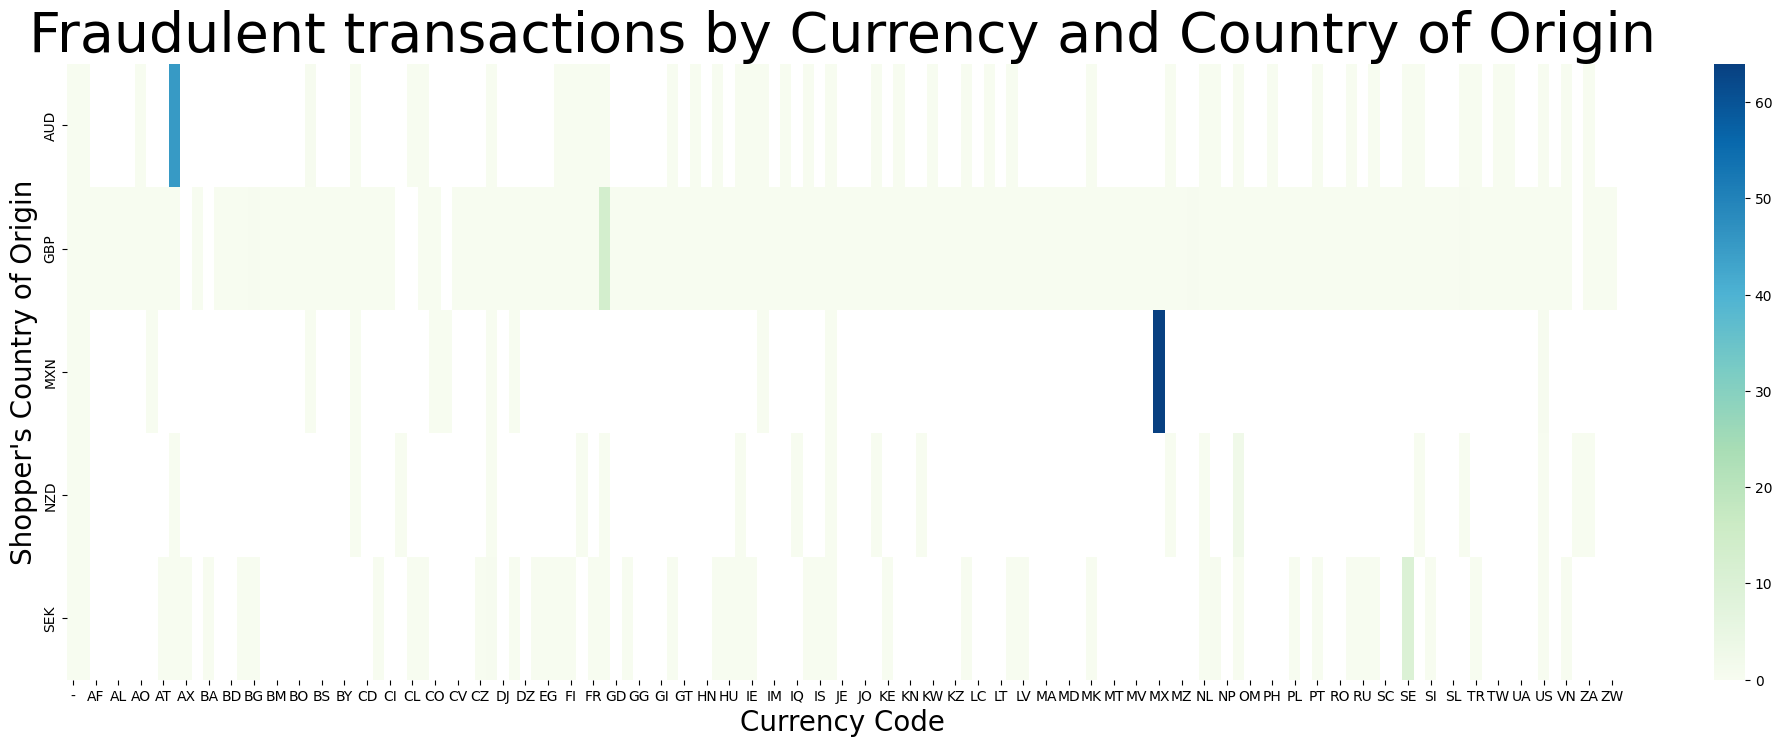

In [160]:
_, ax = plt.subplots(1, figsize=(25, 8))
sns.heatmap(fraud_df, cmap="GnBu")
ax.set_xlabel("Currency Code", fontsize=20)
ax.set_ylabel("Shopper's Country of Origin", fontsize=20)
ax.set_title('Fraudulent transactions by Currency and Country of Origin', fontsize=40)
plt.show()

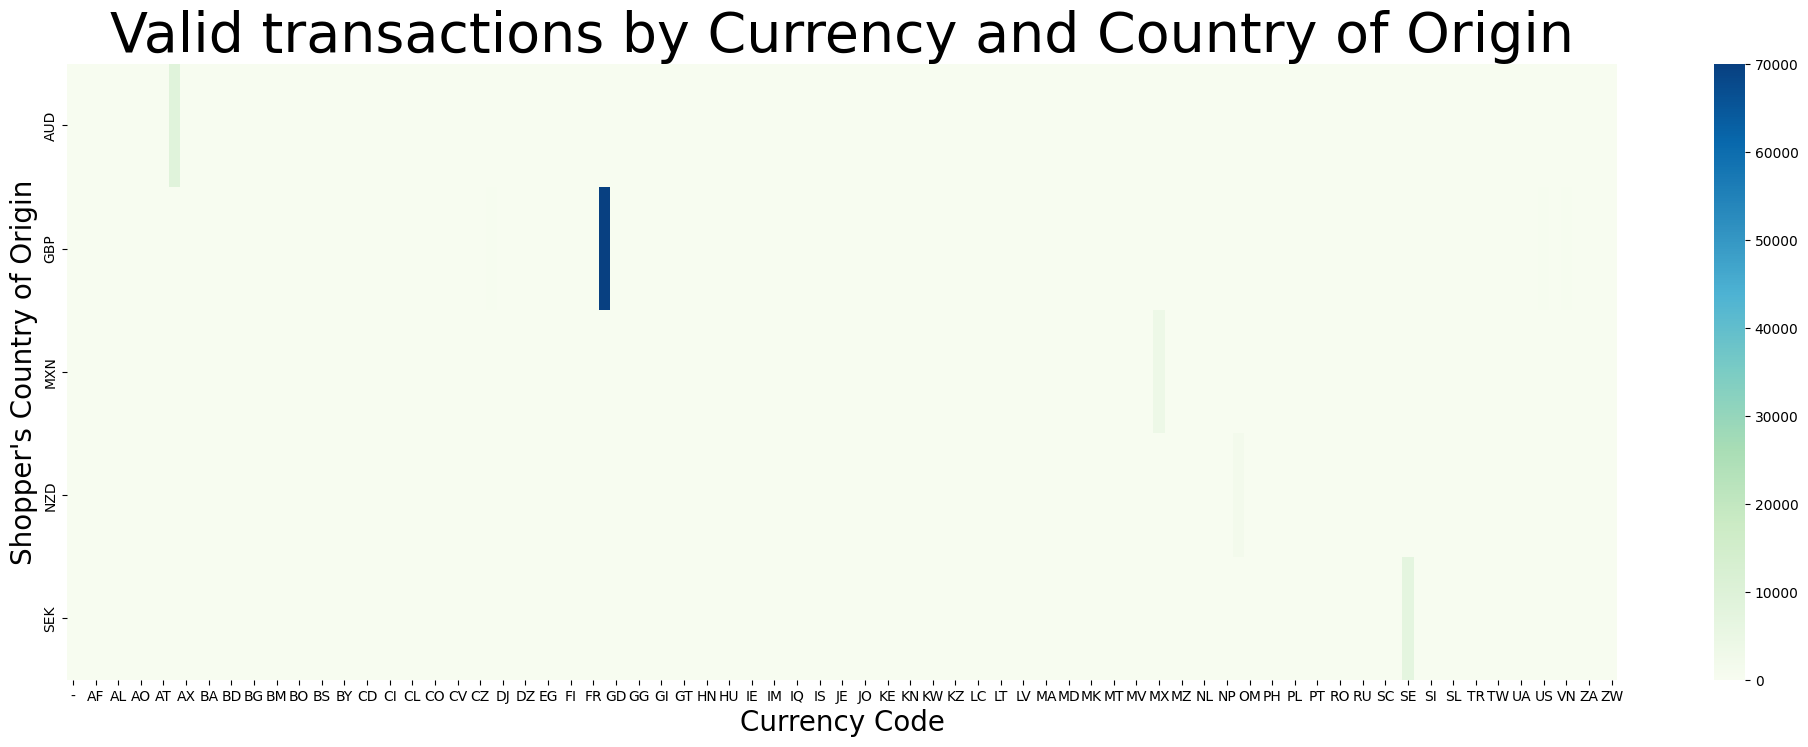

In [157]:
_, ax = plt.subplots(1, figsize=(25, 8))
sns.heatmap(valid_df, cmap="GnBu")
ax.set_xlabel("Currency Code", fontsize=20)
ax.set_ylabel("Shopper's Country of Origin", fontsize=20)
ax.set_title('Valid transactions by Currency and Country of Origin', fontsize=40)
plt.show()

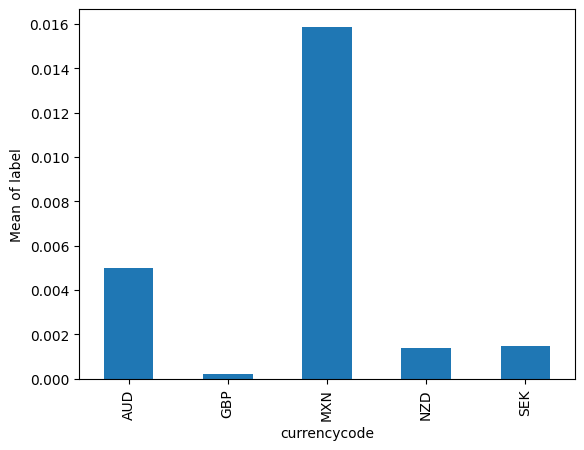

In [163]:
# Group by currency type and plot the mean of the label
train_data_df.groupby('currencycode')['label'].mean().plot(kind='bar')
plt.ylabel('Mean of label')
plt.show()

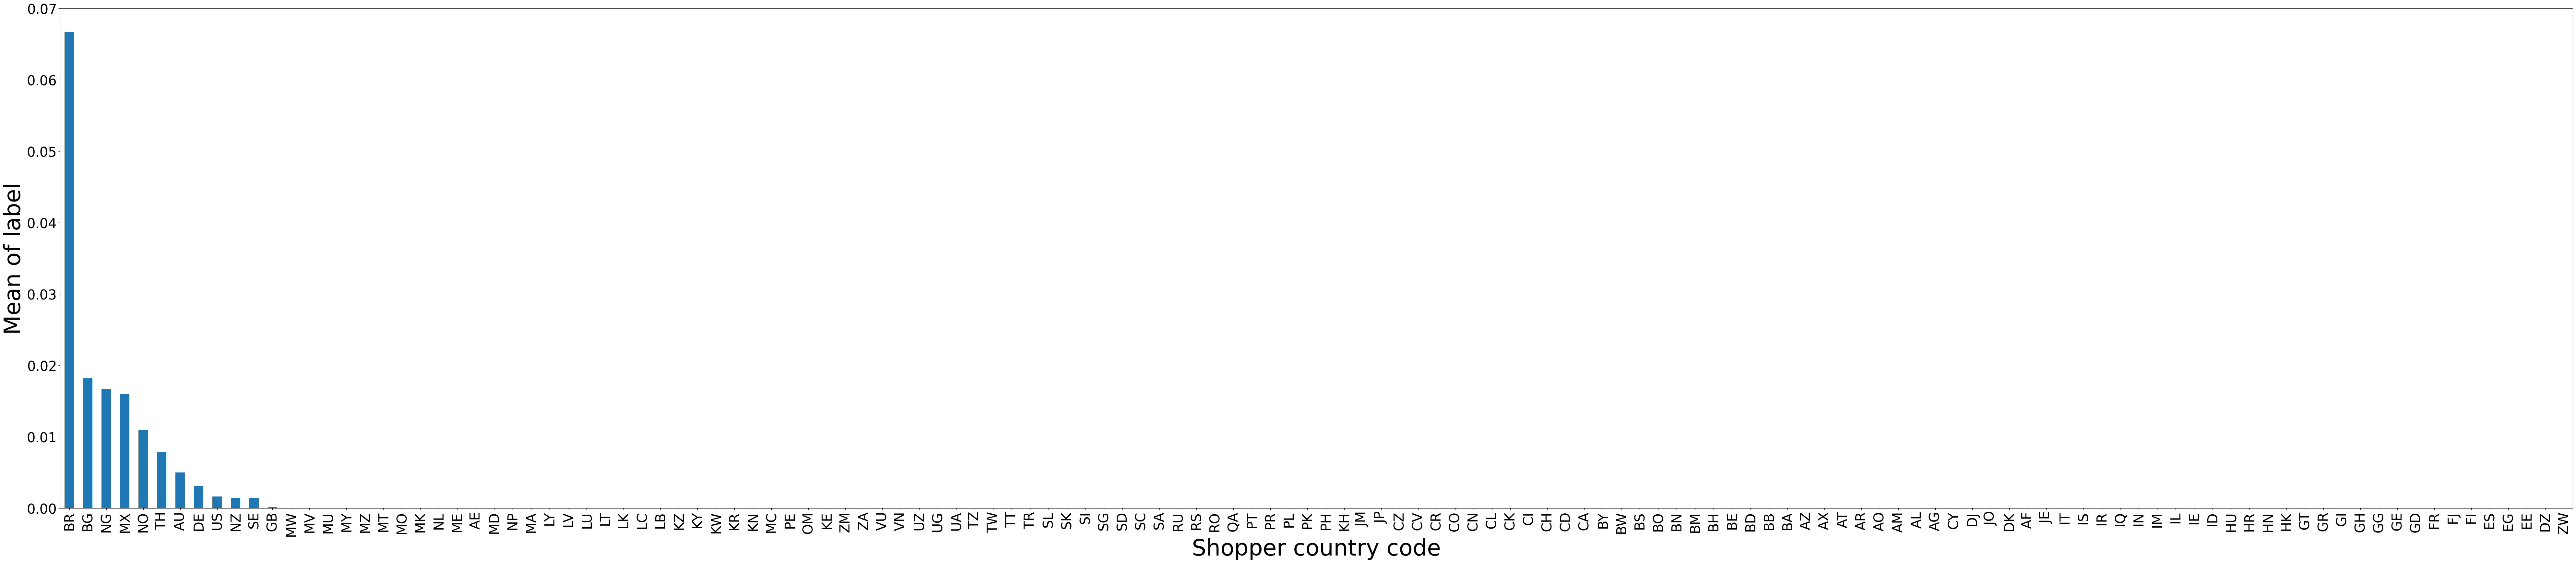

In [165]:
# Group by shopper country code and plot the mean of the label
plt.figure(figsize=(100, 20))
train_data_df.groupby('shoppercountrycode')['label'].mean().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Mean of label', fontsize=50)
plt.xlabel('Shopper country code', fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

<Figure size 10000x2000 with 0 Axes>

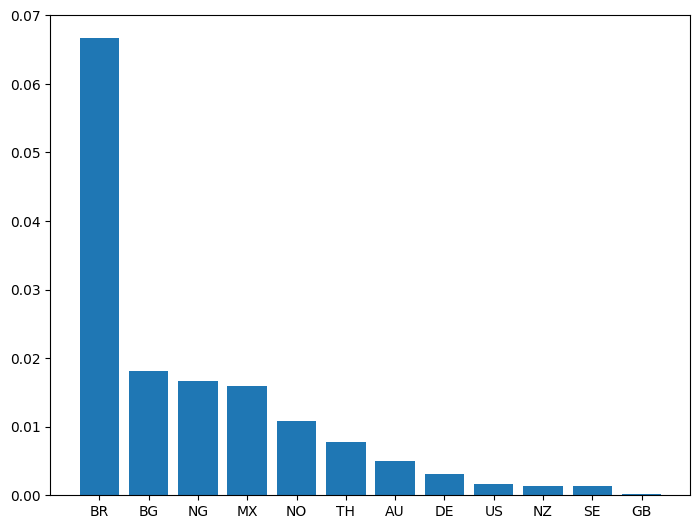

In [198]:
plt.figure(figsize=(100, 20))
fraudulent_mean_data = train_data_df.groupby('shoppercountrycode')['label'].mean()
fraudulent_mean_data = pd.DataFrame(fraudulent_mean_data).reset_index()
fraudulent_mean_data = fraudulent_mean_data[fraudulent_mean_data['label'] > 0.0]
fraudulent_mean_data = fraudulent_mean_data.sort_values(ascending=False, by='label')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
contries = fraudulent_mean_data['shoppercountrycode'].to_list()
mean_fraud = fraudulent_mean_data['label'].to_list()
ax.bar(contries,mean_fraud)
plt.show()

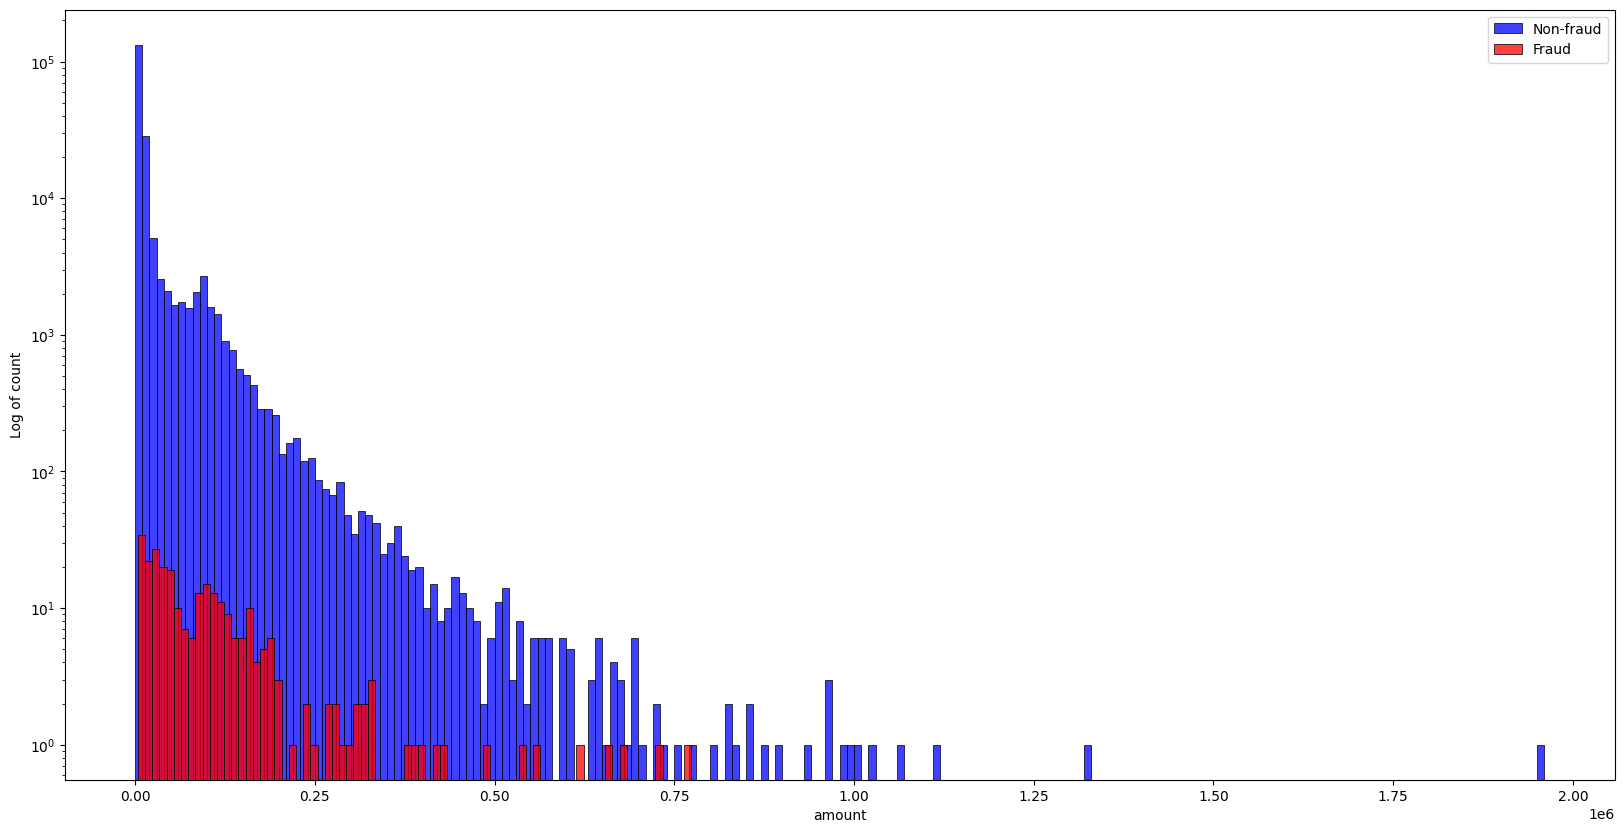

In [167]:
# Plot the distribution of the amount depending on the label
df_amount_fraud = train_data_df[train_data_df['label'] == 1]['amount']
df_amount_non_fraud = train_data_df[train_data_df['label'] == 0]['amount']
plt.figure(figsize=(20, 10))
sns.histplot(df_amount_non_fraud, color='blue', label='Non-fraud', log_scale=(False, True), binwidth=10000)
sns.histplot(df_amount_fraud, color='red', label='Fraud', log_scale=(False, True), binwidth=10000)
plt.ylabel("Log of count")
plt.legend()
plt.show()

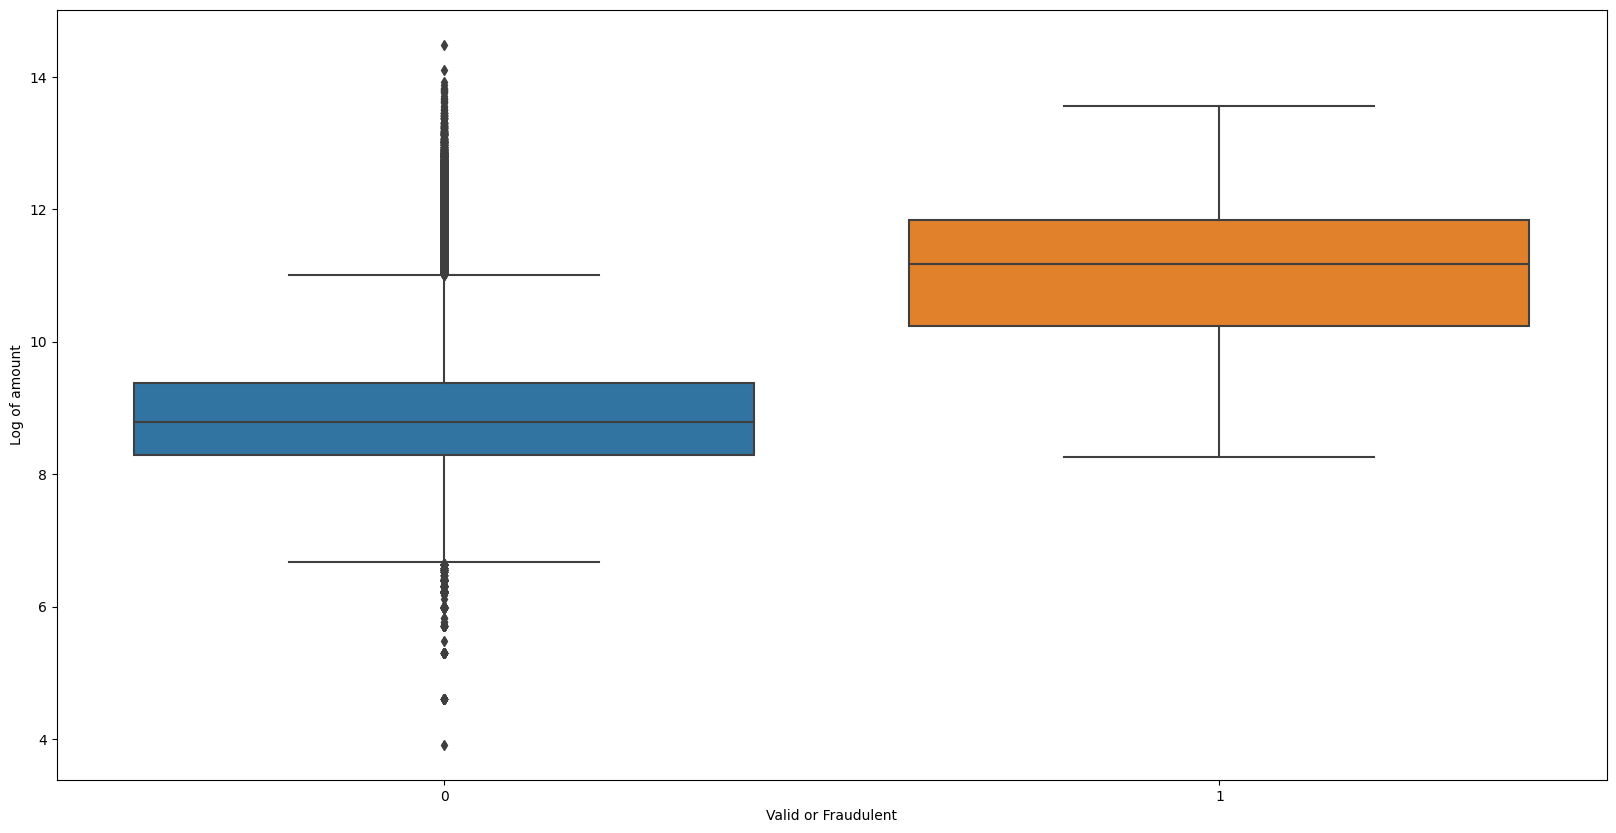

In [169]:
# Create a boxplot of the log of amount depending on the label
plt.figure(figsize=(20, 10))
sns.boxplot(x='label', y=np.log(train_data_df['amount']), data=train_data_df)
plt.ylabel("Log of amount")
plt.xlabel("Valid or Fraudulent")
plt.show()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

## 2. Imbalance task – 1 A4 – Individual

### 2a. Print ROC curves

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

### 2c. Is using SMOTE a good idea? Why (not)?

## 3. Privacy task – 1 A4 – Individual

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below